## Python Implementation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import date
import json
#!pip3 install --upgrade git+https://github.com/JustAnotherArchivist/snscrape@master



In [4]:
df = pd.read_csv('https://www.dropbox.com/s/hc6s8nu0nt7mw03/linking_table.csv?dl=1')

In [5]:
def get_tweet_links_from_username(username):
    """
    Get tweet urls from a username
    """#--format {{date}};{{content}};{{user}};{{id}} 
    command = f"snscrape --jsonl twitter-user {username}  > result_{username}.txt"
    print(f"Running in terminal: {command}")
    output = os.system(command)
    if output != 0:
        print("Error running command")
        return None

    # Read in the result as a list of json objects
    with open(f"result_{username}.txt", "r") as f:
        lines = f.readlines()
        json_objects = [json.loads(line) for line in lines]

    return json_objects
        





In [6]:
tweets = get_tweet_links_from_username(df.username.iloc[0])


Running in terminal: snscrape --jsonl twitter-user AltairAdvisers  > result_AltairAdvisers.txt


In [7]:
# Get all tweets (takes a lot of time DO NOT RUN)
tweets = []
for username in df.username.iloc[:1]:
    tweets.extend(get_tweet_links_from_username(username))

Running in terminal: snscrape --jsonl twitter-user AltairAdvisers  > result_AltairAdvisers.txt


## Preloaded database

In [8]:
df = pd.read_csv('https://www.dropbox.com/s/3qxyxquztrw7rik/tweets.csv?dl=1', delimiter=';', lineterminator='\n')

In [9]:
len(df)

1647523

In [10]:
df.head()

,id,text,date,username\r
0,20180491,Checkn out Twitter. Hello world!,2007-04-05 19:02:05,WellsFargo\r
1,780908027,Im the 221st person to take the pledge!,2008-04-01 16:04:51,moneymanagement\r
2,780938461,Just posted my first blog entry about taking S...,2008-04-01 16:56:58,moneymanagement\r
3,781023623,Keep wishing people Happy Financial Literacy M...,2008-04-01 19:35:11,moneymanagement\r
4,781544668,Just took the quiz on Step 2 @www.financiallit...,2008-04-02 15:42:51,moneymanagement\r


## POS Tagger and Tokenization - Training Sample

In [11]:
from nltk.tokenize import TweetTokenizer
custom_sent_tokenizer=TweetTokenizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import nltk
nltk.download('averaged_perceptron_tagger')
from collections import Counter
from tqdm import tqdm
from scipy import stats

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Juan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [49]:
df = pd.read_csv('https://www.dropbox.com/s/b9xfc46e2dmgb28/training.1600000.processed.noemoticon.csv?dl=1', lineterminator='\n', encoding='latin-1', 
names=['sentiment', 'id', 'date', 'query', 'user', 'text'])
# Keep only text and sentiment
df = df[['sentiment', 'text']]
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [13]:
# Create a function to clean the text and compute the POS
def clean_text(text):
    tokens = custom_sent_tokenizer.tokenize(text)
    # Lowercase all tokens
    tokens = [token.lower() for token in tokens]
    # Remove all punctuation
    tokens = [token for token in tokens if token.isalpha()]
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    # Part of speech of each token
    tagged = nltk.pos_tag(tokens)
    return tagged

In [14]:
# Choose a random subsample of the data
# Set seed for pandas

df = df.sample(frac=0.01, random_state=42)
df.head()

,sentiment,text
541200,0,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,@TiannaChaos i know just family drama. its la...
285055,0,School email won't open and I have geography ...
705995,0,upper airways problem


In [15]:
# Get all features
features = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    features.extend(clean_text(row['text']))


100%|██████████| 16000/16000 [00:13<00:00, 1202.09it/s]


In [16]:
len(features)

108481

In [17]:
counter = Counter(features)

In [18]:
most_common = counter.most_common(500)
most_common = [x[0] for x in most_common]

In [19]:
# We vectorize the words and POS of each tweet

vectors = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    words_pos = clean_text(row['text'])
    vector = [1 if x in words_pos else 0 for x in most_common ]
    vectors.append(vector)


100%|██████████| 16000/16000 [00:14<00:00, 1076.90it/s]


In [20]:
# We convert vectors into a numpy matrix
X = np.array(vectors)
y = df.sentiment.apply(lambda x: 1 if x == 4 else 0) # We are trying to estimate positiveness for the moment

In [21]:
# We will have a group of classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier




In [22]:
abstract_models = [
LogisticRegression,
LinearRegression,
SVC,
RandomForestClassifier,
KNeighborsClassifier,
GaussianNB,
DecisionTreeClassifier,
AdaBoostClassifier,
GradientBoostingClassifier]

trained_models=[]
for am in tqdm(abstract_models):
    model = am()
    model.fit(X, y)
    model.predict(X)
    trained_models.append(model)

100%|██████████| 9/9 [04:12<00:00, 28.10s/it]


In [23]:
def voting_scheme(X):
    ys=[]
    for tm in tqdm(trained_models):
        y_hat = np.round(tm.predict(X), decimals=0) 
        ys.extend(y_hat)
    
    # Convert it to a matrix
    vs = np.array(ys).reshape(X.shape[0], len(trained_models))

    # We return the classification and the voting scheme
    return (stats.mode(vs, axis = 1)[0], np.mean(vs, axis = 1))

In [24]:
# Compute the voting scheme and classification for the MF tweets, 
df = pd.read_csv('tweets.csv', delimiter=';', lineterminator='\n')

In [25]:
df = df.sample(frac=0.01, random_state=42)

In [26]:
# Remove nan from text in df
df = df[df.text.notnull()]

# Build matrix X
vectors = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    words_pos = clean_text(row['text'])
    vector = [1 if x in words_pos else 0 for x in most_common ]
    vectors.append(vector)

X = np.array(vectors)


100%|██████████| 16040/16040 [00:16<00:00, 962.34it/s] 


In [27]:
classification, voting = voting_scheme(X)

100%|██████████| 9/9 [01:30<00:00, 10.10s/it]


## Latent Dirichlet Allocation

In [32]:
# First we need the text tokenized
docs = df.text.apply(lambda x: [l[0] for l in clean_text(x)]).tolist()

In [33]:
docs[0]

['stocks',
 'risen',
 'dollar',
 'year',
 'expect',
 'gap',
 'widen',
 'quarterly',
 'review']

In [34]:
print("Checking stopwords that were not filtered")
sw = ['http', 'url', 'tinyurl', 'twurl', 'com', 'html', 'www', 'bit', 'ly', 'amp', 'u']
for (i_d,doc) in tqdm(enumerate(docs)):
    temp = doc
    for token in doc:
        if token in sw:
            temp.remove(token)
    docs[i_d] = temp

Checking stopwords that were not filtered


16040it [00:00, 502582.03it/s]


In [35]:
from gensim.models import Phrases
# Remove rare and common tokens.
from gensim.corpora import Dictionary
# Train LDA model.
from gensim.models import LdaModel, LdaMulticore

bigram = Phrases(docs, min_count=20)
for idx in tqdm(range(len(docs))):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

100%|██████████| 16040/16040 [00:00<00:00, 66837.45it/s]


In [36]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents
dictionary.filter_extremes(no_below=20)

In [37]:
corpus = [dictionary.doc2bow(doc) for doc in docs]
# %%
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1447
Number of documents: 16040


In [38]:
num_topics = 3
chunksize = 20000
passes = 20
iterations = 100
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [41]:
lda = LdaModel(corpus, num_topics=3, 
id2word=id2word, chunksize=chunksize, 
passes=passes, iterations=iterations, 
 eval_every=eval_every)

In [43]:
top_topics = lda.top_topics(corpus)

In [44]:
  # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)
from pprint import pprint
pprint(top_topics)

Average topic coherence: -3.8962.
[([(0.036659658, 'us'),
   (0.03549776, 'thanks'),
   (0.031539045, 'hi'),
   (0.029017415, 'please'),
   (0.017364005, 'help'),
   (0.013832076, 'call'),
   (0.013176686, 'dm'),
   (0.012902969, 'like'),
   (0.012391305, 'sorry'),
   (0.011317874, 'team'),
   (0.010926629, 'thank'),
   (0.010462812, 'hear'),
   (0.009914886, 'contact'),
   (0.00985328, 'account'),
   (0.00926141, 'would'),
   (0.009261175, 'know'),
   (0.008847379, 'happy'),
   (0.007961844, 'number'),
   (0.007422236, 'send'),
   (0.007189144, 'phone')],
  -2.3390221644879423),
 ([(0.012550426, 'new'),
   (0.012247591, 'market'),
   (0.0097434195, 'learn'),
   (0.007744526, 'today'),
   (0.0076405252, 'financial'),
   (0.0075628515, 'year'),
   (0.0075521977, 'investment'),
   (0.0074730767, 'see'),
   (0.006846096, 'global'),
   (0.0065942053, 'read'),
   (0.0065796855, 'investors'),
   (0.006075154, 'week'),
   (0.0056344573, 'ipo'),
   (0.005414801, 'via'),
   (0.005019781, 'marke

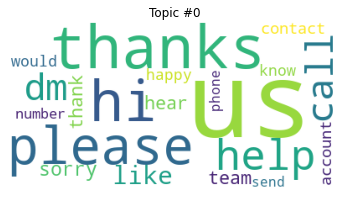

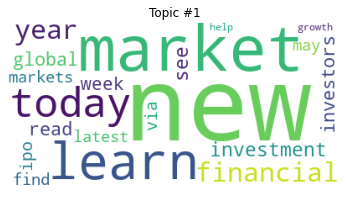

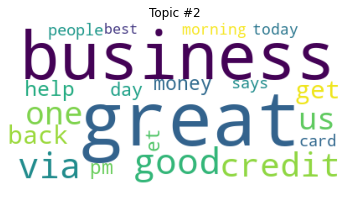

In [48]:
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud, STOPWORDS
    for i_t, t in enumerate(top_topics):
        freqs = t[0]
        info = {}
        for f in freqs:
            info[f[1]] = f[0]

        plt.figure()
        plt.imshow(WordCloud(background_color='white').fit_words(info))
        plt.axis("off")
        plt.title("Topic #" + str(i_t))
        plt.show()